In [112]:
import pandas as pd
import numpy as np
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Read in data

We read in train and do some initial analysis

In [97]:
train = pd.read_csv('data/train.csv')

In [72]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
len(train)

891

In [74]:
train.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [108]:
features = set(train.columns) - set(('Cabin', 'Name', 'Ticket', 'Embarked', 'PassengerId'))
features = list(features)
features

['Age', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex']

In [105]:
train[~train.isnull()][features].head()

,PassengerId,Age,Survived,Pclass,SibSp,Parch,Fare,Sex
0,1,22.0,0,3,1,0,7.2500,0
1,2,38.0,1,1,1,0,71.2833,1
2,3,26.0,1,3,0,0,7.9250,1
3,4,35.0,1,1,1,0,53.1000,1
4,5,35.0,0,3,0,0,8.0500,0


In [100]:
train['Sex'] = train['Sex'].apply(lambda x: 1 if x=='female' else 0)

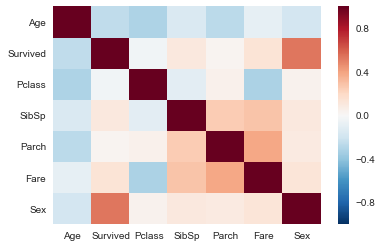

In [114]:
sns.heatmap(train.dropna()[features].corr())

In [115]:
len(train.dropna())

183

# Imputation

Age is causing a lot of records to be dropped, let's impute it

In [116]:
from collections import Counter
counter = Counter(' '.join([x for x in train['Name'].values]).lower().split(' '))

In [117]:
counter.most_common(20)

[('mr.', 517),
 ('miss.', 182),
 ('mrs.', 125),
 ('william', 62),
 ('john', 44),
 ('master.', 40),
 ('henry', 33),
 ('james', 24),
 ('charles', 23),
 ('george', 22),
 ('thomas', 21),
 ('edward', 18),
 ('joseph', 16),
 ('johan', 15),
 ('frederick', 15),
 ('mary', 13),
 ('richard', 13),
 ('samuel', 13),
 ('arthur', 13),
 ('alfred', 12)]

In [118]:
mr_mrs_dict={'mr.': 1, 'mrs.': 2}
miss_master_dict={'master.': 1, 'miss.': 2}
def assign_label(string, dictionary):
    for key in dictionary.keys():
        if key in string.lower():
            return dictionary[key]
    return 0
train['mr_mrs'] = train['Name'].apply(lambda x: assign_label(x, mr_mrs_dict))
train['master_miss'] = train['Name'].apply(lambda x: assign_label(x, miss_master_dict))

In [119]:
mr_mrs_dict = train[~train['Age'].isnull()][['mr_mrs','Age']].groupby('mr_mrs').agg('median').to_dict()
master_miss_dict = train[~train['Age'].isnull()][['master_miss','Age']].groupby('master_miss').agg('median')

In [120]:
train.loc[(train['Age'].isnull()) & (train['mr_mrs']==1), 'Age'] = mr_mrs_dict['Age'][1]
train.loc[(train['Age'].isnull()) & (train['mr_mrs']==2), 'Age'] = mr_mrs_dict['Age'][2]
train.loc[(train['Age'].isnull()) & (train['master_miss']==1), 'Age'] = master_miss_dict['Age'][1]
train.loc[(train['Age'].isnull()) & (train['master_miss']==2), 'Age'] = master_miss_dict['Age'][2]

In [121]:
train.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              1
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
mr_mrs           0
master_miss      0
dtype: int64

In [147]:
train = train[(~train['Age'].isnull()) & (~train['Embarked'].isnull())]

In [124]:
len(train)

888

# Feature Engineering

In [148]:
import re
train['Ticket_num'] = train['Ticket'].apply(lambda x: -1 if ~x.split(' ')[-1].isdigit() else int(x.split(' ')[-1]))

In [149]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=.3, random_state=42)

In [150]:
features.append('Ticket_num')

In [151]:
features

['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex', 'Ticket_num', 'Ticket_num']

In [152]:
features.remove('Survived')

ValueError: list.remove(x): x not in list

# Linear Model

In [153]:
logits = LogisticRegression()
logits.fit(train[features], train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Age           float64
Pclass          int64
SibSp           int64
Parch           int64
Fare          float64
Sex             int64
Ticket_num     object
dtype: object